In [18]:
## Code to extract the reads counts for the SNP positions and their neighbours
## The first step of the process is to create dataframes of read counts for each SNP and their neighbours. 
## Only the CSV files will be included in the repository, as the vcf files are too large, but here we show how they can be reconstructed from the raw data.

import pandas as pd
import gzip
import regex as re
## If you want to parallise parts of the code, you can use the pandarallel package
from pandarallel import pandarallel

pandarallel.initialize()

## For the grapevine data, the SNP positions used in the paper are not known, so we extract the SNP positions from the vcf files.
## (Code is commented out as it takes a long time to run)
#!bcftools view BAM/vitis_vinifera/Vgir_scion.SRR2015295_1.fastq.raw.bcf > BAM/vitis_vinifera/Vgir_scion.SRR2015295_1.fastq.raw.vcf
#!bcftools view -v snps BAM/vitis_vinifera/Vgir_scion.SRR2015295_1.fastq.raw.vcf -o Vgir_scion_snps_only.vcf

## We then extract the SNP positions from the vcf file: the remaining code in this cell takes ~ 4 minutes to run.
## Process the VCF file with the SNP positions (vcf file is not included in the repository)
vcf_file = "../Data/Vgir_scion_snps_only.vcf"

## Get the names of the columns
def get_vcf_names(vcf_path):
    ## Check if file is gzipped
    if vcf_path.endswith(".gz"):
        with gzip.open(vcf_path, "rt") as ifile:
          for line in ifile:
            if line.startswith("#CHROM"):
                  vcf_names = [x for x in line.split('\t')]
                  break
    else:
      with open(vcf_path, "rt") as ifile:
            for line in ifile:
              if line.startswith("#CHROM"):
                    vcf_names = [x for x in line.split('\t')]
                    break
    ifile.close()
    return vcf_names

## Function to parse the vcf file and extract the read counts
def parseInfo(row):
    info_split = row.split(";")
    info = [i for i in info_split if i.startswith('AD=')]
    output = re.findall(r'\d+', info[0])
    return output

## This function parses the vcf file and extracts the read counts for the SNPs
def parse_vcf(vcf_file):
  df_list = []
  for chunk in vcf_file:
      ## NB: If you choose not to use pandarallel, this line can be replaced with the following:
      ## chunk["INFO"] = chunk["INFO"].apply(lambda x: parseInfo(x))
      chunk["INFO"] = chunk["INFO"].parallel_apply(lambda x: parseInfo(x))
      df_list.append(chunk)

  df_final_snps = pd.concat(df_list)
  return df_final_snps



INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [20]:
## Process the grapevine vcf file containing the SNP positions
names = get_vcf_names(vcf_file)
df_vcf_snps = pd.read_csv(vcf_file, comment='#', chunksize=10000, sep=r'\s+', header=None, names=names,usecols=["#CHROM","POS","REF","ALT","QUAL","INFO"])
df_final_snps = parse_vcf(df_vcf_snps)

grapevine_snps = df_final_snps["#CHROM"].astype(str) + "_" + df_final_snps["POS"].astype(str)
grapevine_snp_list = grapevine_snps.to_list()
# Convert the list to a pandas Series and save it to a CSV file
pd.Series(grapevine_snp_list).to_csv("../Data/grapevine_snp_list.csv", index=False)


## For the Thieme data, we use the SNPs provided in the supplementary data of the paper
## NB: the SNP list is incomplete, as the full list is not available, so we reconstructed the list from the data. 
thieme_snps = pd.read_csv("../Data/thieme_og_snp_list.csv")
thieme_snp_list = thieme_snps["SNP"].to_list()

In [10]:
## The next step is to create the list of neighbours from the list of SNPs

def get_neighbours(snp_list):
    neighbours_list = []
    for snp in snp_list:
        chrom = snp.split("_")[0]
        pos = int(snp.split("_")[1])
        neighbours_list.append(chrom + "_" + str(pos + 1))
        neighbours_list.append(chrom + "_" + str(pos - 1))
    return neighbours_list

thieme_neighbours = get_neighbours(thieme_snp_list)
grapevine_neighbours = get_neighbours(grapevine_snp_list)

## Save the SNP and neighbour positions to a txt file
# Combine SNPs and neighbors into a single list
combined_thieme_list = thieme_snp_list + thieme_neighbours
combined_grapevine_list = grapevine_snp_list + grapevine_neighbours

# Sort the combined list
sorted_thieme_list = sorted(combined_thieme_list, key=lambda x: (x.split("_")[0], int(x.split("_")[1])))
sorted_grapevine_list = sorted(combined_grapevine_list, key=lambda x: (x.split("_")[0], int(x.split("_")[1])))

# Write the sorted list to the file in the format "Chr + #chrom \t pos"
with open("../Data/thieme_positions.txt", "w") as f:
    for snp in sorted_thieme_list:
        chrom, pos = snp.split("_")
        f.write(f"{chrom}\t{pos}\n")

with open("../Data/grapevine_positions.txt", "w") as f:
    for snp in sorted_grapevine_list:
        chrom, pos = snp.split("_")
        f.write(f"{chrom}\t{pos}\n")


In [ ]:
## We then filter the files to extract the read counts for the SNP positions and their neighbours
## Example code here, but commented out due to the length of time to run it

#!bgzip ../Data/Vgir_scion.SRR2015295_1.fastq.raw.vcf

# Sort the gzip file
#!bcftools sort ../Data/Vgir_scion.SRR2015295_1.fastq.raw.vcf.gz -o ../Data/Vgir_scion.SRR2015295_1.fastq.raw.sorted.vcf.gz

# Index the VCF file (takes about 2 minutes)
#!tabix -p vcf ../Data/Vgir_scion.SRR2015295_1.fastq.raw.sorted.vcf.gz

# Extract specific SNP positions
#!tabix ../Data/Vgir_scion.SRR2015295_1.fastq.raw.vcf.gz ../Data/formatted_positions.txt > ../Data/filtered.vcf

# Filter by the SNP positions file - this is takes a long time
#!bcftools view --threads 4 -R ../Data/positions.txt -O v -o ../Data/filtered_output_grapevine.vcf ../Data/Vgir_scion.SRR2015295_1.fastq.raw.sorted.vcf.gz



In [3]:
## We now have filtered files for Thieme and grapevine data, which we can use to extract the read counts for the SNP positions and their neighbours
import pandas as pd

## Run for the thieme data
filtered_vcf_thieme = "../Data/filtered_output_thieme.vcf"
names = get_vcf_names(filtered_vcf_thieme)
df_vcf_thieme = pd.read_csv(filtered_vcf_thieme, comment='#', chunksize=10000, sep=r'\s+', header=None, names=names,usecols=["#CHROM","POS","REF","ALT","QUAL","INFO"])
df_final_thieme = parse_vcf(df_vcf_thieme)

## Run for the grapevine data
filtered_vcf_grapevine = "../Data/filtered_output_grapevine.vcf"
names = get_vcf_names(filtered_vcf_grapevine)
df_vcf_grapevine = pd.read_csv(filtered_vcf_grapevine, comment='#', chunksize=10000, sep=r'\s+', header=None, names=names,usecols=["#CHROM","POS","REF","ALT","QUAL","INFO"])
df_final_grapevine = parse_vcf(df_vcf_grapevine)

In [6]:
## Save the processed data
df_final_thieme.to_csv("../Data/df_final_thieme.csv")
df_final_grapevine.to_csv("../Data/df_final_grapevine.csv")

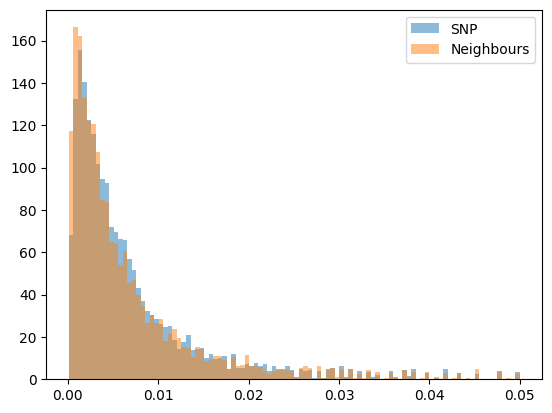

/var/folders/t5/q1tt12hd2sg29kw894zcfbtm000b_5/T/ipykernel_49367/1702998102.py:29: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_final_grapevine = pd.read_csv("../Data/df_final_grapevine.csv")


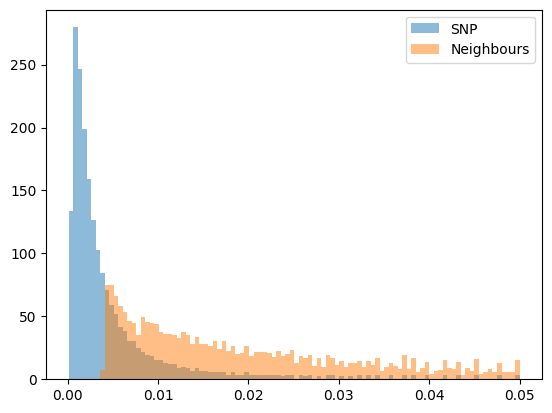

In [24]:
## Plot the data
import matplotlib.pyplot as plt

## Thieme. Load in the SNP positions
df_thieme_snps = pd.read_csv("../Data/thieme_og_snp_list.csv")
thieme_snps = df_thieme_snps["SNP"].to_list()

## Load in the processed dataframe
df_final_thieme = pd.read_csv("../Data/df_final_thieme.csv")

## Ensure INFO column is parsed correctly
df_final_thieme["INFO"] = df_final_thieme["INFO"].apply(lambda x: eval(x) if isinstance(x, str) else x)

## Create the [n:N] ratio column as the ratio of the second element of the INFO column to the sum of the first and second
df_final_thieme["n:N"] = df_final_thieme["INFO"].apply(lambda x: int(x[1])/(int(x[0]) + int(x[1])) if len(x) > 1 and (int(x[0]) + int(x[1])) != 0 else None)

## Create the SNP column
df_final_thieme["SNP"] = df_final_thieme["#CHROM"].astype(str) + "_" + df_final_thieme["POS"].astype(str)

plt.hist(df_final_thieme[df_final_thieme["SNP"].isin(thieme_snps)]["n:N"], bins = 100, alpha = 0.5, density = True, range = (0.0001,0.05), label = "SNP")
plt.hist(df_final_thieme[~df_final_thieme["SNP"].isin(thieme_snps)]["n:N"], bins = 100, alpha = 0.5, density = True, range = (0.0001,0.05), label = "Neighbours")
plt.legend()
plt.show()

## Grapevine (processed files are too big to include in the repository)
df_grapevine_snps = pd.read_csv("../Data/grapevine_snp_list.csv", sep = "\t", header = None, low_memory=False)
grapevine_snps = df_grapevine_snps[0].to_list()

df_final_grapevine = pd.read_csv("../Data/df_final_grapevine.csv",low_memory=False)

df_final_grapevine["INFO"] = df_final_grapevine["INFO"].apply(lambda x: eval(x) if isinstance(x, str) else x)

df_final_grapevine["n:N"] = df_final_grapevine["INFO"].apply(lambda x: int(x[1])/(int(x[0]) + int(x[1])) if len(x) > 1 and (int(x[0]) + int(x[1])) != 0 else None)

df_final_grapevine["SNP"] = df_final_grapevine["#CHROM"].astype(str) + "_" + df_final_grapevine["POS"].astype(str)

plt.hist(df_final_grapevine[df_final_grapevine["SNP"].isin(grapevine_snps)]["n:N"], bins = 100, alpha = 0.5, density = True, range = (0.0001,0.05), label = "SNP")
plt.hist(df_final_grapevine[~df_final_grapevine["SNP"].isin(grapevine_snps)]["n:N"], bins = 100, alpha = 0.5, density = True, range = (0.0001,0.05), label = "Neighbours")
plt.legend()
plt.show()

In [30]:
## Save the outputs to a csv file, for plotting with gnuplot 

df_final_thieme[df_final_thieme["SNP"].isin(thieme_snps)]["n:N"].to_csv("../Data/df_final_thieme_snps.csv", index=None, header=None)
df_final_thieme[~df_final_thieme["SNP"].isin(thieme_snps)]["n:N"].to_csv("../Data/df_final_thieme_neighbours.csv", index=None, header=None)

## Grapevine (processed files are too big to include in the repository)
df_final_grapevine[df_final_grapevine["SNP"].isin(grapevine_snps)]["n:N"].to_csv("../Data/df_final_grapevine_snps.csv", index=None, header=None)
df_final_grapevine[~df_final_grapevine["SNP"].isin(grapevine_snps)]["n:N"].to_csv("../Data/df_final_grapevine_neighbours.csv", index=None, header=None)